# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import glob
from scipy.stats.stats import pearsonr
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import f1_score, balanced_accuracy_score, mean_squared_error, r2_score

In [2]:
# which datasets to read and write

do_indian_pines = True 
do_salient_objects = True
do_plastic_flakes = True
do_soil_moisture = True


## Define functions

In [3]:
# reward functions

def calculate_correlations(data, num_bands_originally, num_bands_kept):
    
    selected_bands = np.random.randint(0,num_bands_originally,num_bands_kept)
    corr_sum = 0
    for i in selected_bands:
        for j in selected_bands:
            
            corr_sum += np.abs(pearsonr(data[:, i], 
                                 data[:, j])[0])
            
    return corr_sum/(len(selected_bands)**2)


def calculate_mutual_infos(data, num_bands_originally, num_bands_kept):
    
    selected_bands = np.random.randint(0,num_bands_originally,num_bands_kept)
    normalized_mutual_info_score_sum = 0
    for i in selected_bands:
        for j in selected_bands:
            
            normalized_mutual_info_score_sum += normalized_mutual_info_score(data[:, i],
                                                                             data[:, j])
            
    return normalized_mutual_info_score_sum/(len(selected_bands)**2)


In [4]:
## dataset loading

def load_datasets(Dataset):
    
    if Dataset == 'SM':
        hyper_path = '../data/soil_moisture/hyperspectral_imagery/*npy'
        hyper = np.load(glob.glob(hyper_path)[0])
        gt_path = '../data/soil_moisture/gt_labels/*npy'
        gt = np.load(glob.glob(gt_path)[0])
        return hyper, gt
    
    if Dataset == 'IN':
        hyper_path = '../data/indian_pines/hyperspectral_imagery/*npy'
        hyper = np.load(glob.glob(hyper_path)[0])
        gt_path = '../data/indian_pines/gt_labels/*npy'
        gt = np.load(glob.glob(gt_path)[0])
        return hyper, gt
    
    if Dataset == 'SO':
        hyper_path = '../data/salient_objects/hyperspectral_imagery/*npy'
        gt_path = '../data/salient_objects/gt_labels/*npy'
        hypers=[]
        gt_labels=[]
        for i in range(len(glob.glob(hyper_path))):
            hyper = np.load(glob.glob(hyper_path)[i])
            hypers.append(hyper)
            gt = np.load(glob.glob(gt_path)[i])
            gt_labels.append(gt)
        return hypers, gt_labels

                          
    if Dataset == 'PF':
        hyper_path = '../data/plastic_flakes/hyperspectral_imagery/*npy'
        gt_path = '../data/plastic_flakes/gt_labels/*npy'
        hypers=[]
        gt_labels=[]
        for i in range(len(glob.glob(hyper_path))):
            hyper = np.load(glob.glob(hyper_path)[i])
            hypers.append(hyper)
            gt = np.load(glob.glob(gt_path)[i])
            gt_labels.append(gt)
        return hypers, gt_labels
    


In [28]:
def normalize(data, mean, std): 
    return (data - mean) / std


def baseline_supervised_pass(data_fpath, labels_fpath, Dataset, random_subset=False, num_random_bands=15):
    
    # train val split
    data = np.load(data_fpath)
    if random_subset:
        indices = np.random.randint(0, data.shape[1], num_random_bands)
        data = data[:,indices]
        
    print(data.shape)

    labels = np.load(labels_fpath)
    
    if Dataset == 'SM':

        train_images, val_images, train_labels, val_labels = train_test_split(data, 
                                                                labels, 
                                                                test_size=0.3, 
                                                                random_state=42)
    
        
        clf = MLPRegressor(hidden_layer_sizes=(150,),
                            activation='logistic',
                            learning_rate='adaptive',
                            max_iter=1000, )
        
        train_mu = np.mean(train_images)
        train_std = np.std(train_images)
        
        train_images = normalize(train_images, train_mu, train_std)
        val_images = normalize(val_images, train_mu, train_std)
        
        clf.fit(train_images, train_labels)
        val_predictions = clf.predict(val_images)
        mse = mean_squared_error(val_labels, val_predictions)
        r2 = r2_score(val_labels, val_predictions)  
        
        return mse, r2        
        
    else:
   
        clf = MLPClassifier(hidden_layer_sizes=(150,),
                            activation='logistic',
                            learning_rate='adaptive',
                            max_iter=1000, )
        
        clf.fit(train_images, train_labels)
        val_predictions = clf.predict(val_images)
        bac = balanced_accuracy_score(val_labels, val_predictions)
        f1 = f1_score(val_labels, val_predictions, average='macro')   
        
        return bac, f1
    

## Soil moisture dataset

In [24]:
# load data

if do_soil_moisture:
    
    hyper, gt = load_datasets(
        'SM')
    
    print('\nDataset info...')
    print('The shape of the original imagery:', hyper.shape)
    print('The shape of the original labels:', gt.shape)
    


Dataset info...
The shape of the original imagery: (679, 125)
The shape of the original labels: (679,)



Correlation reward for random 10 bands, x25 runs: 0.9863772562357045
Normalized mutual information reward for random 10 bands, x25 runs: 0.6951658874246783


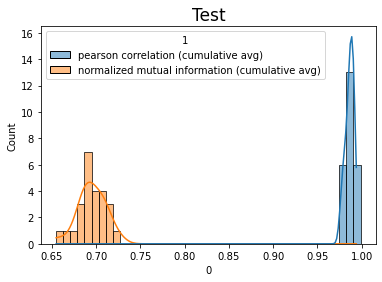

<Figure size 432x288 with 0 Axes>

In [21]:
# rewards
    
if do_soil_moisture:
    num_runs = 25
    
    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=10))
    print(f'\nCorrelation reward for random 10 bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=10))
    print(f'Normalized mutual information reward for random 10 bands, x{num_runs} runs:', np.mean(mis))
    
    # plot rewards
    a_string = ['pearson correlation (cumulative avg)'] * len(correlations)    
    b_string = ['normalized mutual information (cumulative avg)'] * len(mis)
    strings = a_string + b_string
    pd_df = pd.DataFrame([correlations+mis, strings]).T
    pd_df[0] = pd_df[0].astype(float, copy=True)
    sns.histplot(data=pd_df, binwidth=0.008, x=0, hue=1, kde=True)
    plt.title(f'Test', fontsize=17)
    #plt.xlim([0,1])
    plt.show()
    plt.figure()

In [29]:
# baseline models 

# model with all bands included
print(f'Baseline model performance with all bands...')
data_fpath = '../data/soil_moisture/hyperspectral_imagery/soil_moisture_hyper.npy'
labels_fpath = '../data/soil_moisture/gt_labels/soil_moisture_gt.npy'
mse, r2 = baseline_supervised_pass(data_fpath, labels_fpath, 'SM')
print(f'Validation MSE: {mse}')
print(f'Validation r2: {r2}')

# model with random 15 band
data_fpath = '../data/soil_moisture/hyperspectral_imagery/soil_moisture_hyper.npy'
labels_fpath = '../data/soil_moisture/gt_labels/soil_moisture_gt.npy'
mse, r2 = baseline_supervised_pass(data_fpath, labels_fpath, 'SM', True, 30)
print(f'\nBaseline model performance with {30} band random subset...')
print(f'Validation MSE: {mse}')
print(f'Validation r2: {r2}')

Baseline model performance with all bands...
(679, 125)


/Users/danielfurman/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


Validation MSE: 4.3783760989308185
Validation r2: 0.689715431212446
(679, 30)
Baseline model performance with 30 band random subset...
Validation MSE: 6.460159782420363
Validation r2: 0.542184625739098


/Users/danielfurman/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


## Indian Pines dataset

In [ ]:
# load data

if do_indian_pines:
    
    hyper, gt = load_datasets(
        'IN')
    
    print('\nDataset info...')
    print('The shape of the original imagery:', hyper.shape)
    print('The shape of the original labels:', gt.shape)
    

In [ ]:
# rewards
    
if do_indian_pines:
    num_runs = 25
    
    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=10))
    print(f'\nCorrelation reward for random 10 bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper, num_bands_originally=hyper.shape[-1], num_bands_kept=10))
    print(f'Normalized mutual information reward for random 10 bands, x{num_runs} runs:', np.mean(mis))
    
    # plot rewards
    a_string = ['pearson correlation (cumulative avg)'] * len(correlations)    
    b_string = ['normalized mutual information (cumulative avg)'] * len(mis)
    strings = a_string + b_string
    pd_df = pd.DataFrame([correlations+mis, strings]).T
    pd_df[0] = pd_df[0].astype(float, copy=True)
    sns.histplot(data=pd_df, bins=20, x=0, hue=1, kde=True)
    plt.title(f'Test', fontsize=17)
    #plt.xlim([0,1])
    plt.show()
    plt.figure()

In [ ]:
# baseline models





## Plastic flakes dataset

In [9]:
# stacks all images vertically

# load data

if do_plastic_flakes:
    
    hyper, gt = load_datasets(
        'PF')
    
    hyper, gt = np.array(hyper), np.array(gt)
    
    hyper_multiple = np.empty([hyper.shape[0]*hyper.shape[1], hyper.shape[-1]])
    gt_multiple = np.empty([gt.shape[0]*gt.shape[1]])
    
    print('\nDataset info...')
    print('The shape of the original imagery:', hyper.shape)
    print('The shape of the original labels:', gt.shape)
    
    for i in range(hyper.shape[0]):
        hyper_multiple[i*hyper.shape[1]:(i+1)*hyper.shape[1] , :] = hyper[i, :, :]
        gt_multiple[i*hyper.shape[1]:(i+1)*hyper.shape[1]] = gt[i, :]

    print('The shape of the vertically stacked images:', hyper_multiple.shape)
    print('The shape of the vertically stacked images:', gt_multiple.shape)    



Dataset info...
The shape of the original imagery: (11, 112128, 224)
The shape of the original labels: (11, 112128)
The shape of the vertically stacked images: (1233408, 224)
The shape of the vertically stacked images: (1233408,)


The shape of the sub-sampled vertically stacked images: (61670, 224)

Correlation reward for random 10 bands, x25 runs: 0.9582447481587395
Normalized mutual information reward for random 10 bands, x25 runs: 0.6695426727822139


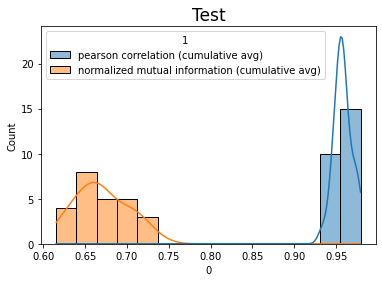

<Figure size 432x288 with 0 Axes>

In [10]:
# rewards
    
if do_plastic_flakes:
    
    num_runs = 25
    
    # randomly sample hyper_multiple for 5% of the pixels
    indices = np.random.randint(0, hyper_multiple.shape[0], int(hyper_multiple.shape[0]*0.05))
    hyper_multiple = hyper_multiple[indices, :]
    print('The shape of the sub-sampled vertically stacked images:', hyper_multiple.shape)
    
    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper_multiple, num_bands_originally=hyper_multiple.shape[-1], num_bands_kept=10))
    print(f'\nCorrelation reward for random 10 bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper_multiple, num_bands_originally=hyper_multiple.shape[-1], num_bands_kept=10))
    print(f'Normalized mutual information reward for random 10 bands, x{num_runs} runs:', np.mean(mis))
    
    # plot rewards
    a_string = ['pearson correlation (cumulative avg)'] * len(correlations)    
    b_string = ['normalized mutual information (cumulative avg)'] * len(mis)
    strings = a_string + b_string
    pd_df = pd.DataFrame([correlations+mis, strings]).T
    pd_df[0] = pd_df[0].astype(float, copy=True)
    sns.histplot(data=pd_df, bins=15, x=0, hue=1, kde=True)
    plt.title(f'Test', fontsize=17)
    #plt.xlim([0,1])
    plt.show()
    plt.figure()

In [11]:
# baseline models



## Salient objects dataset

In [12]:
# stacks all images vertically

# load data

if do_salient_objects:
    
    hyper, gt = load_datasets(
        'SO')
    
    hyper, gt = np.array(hyper), np.array(gt)
    
    hyper_multiple = np.empty([hyper.shape[0]*hyper.shape[1], hyper.shape[-1]])
    gt_multiple = np.empty([gt.shape[0]*gt.shape[1]])
    
    print('\nDataset info...')
    print('The shape of the original imagery:', hyper.shape)
    print('The shape of the original labels:', gt.shape)
    
    for i in range(hyper.shape[0]):
        hyper_multiple[i*hyper.shape[1]:(i+1)*hyper.shape[1] , :] = hyper[i, :, :]
        gt_multiple[i*hyper.shape[1]:(i+1)*hyper.shape[1]] = gt[i, :]

    print('\nDataset info...')
    print('The shape of the vertically stacked images:', hyper_multiple.shape)
    print('The shape of the vertically stacked images:', gt_multiple.shape)    



Dataset info...
The shape of the original imagery: (15, 786432, 81)
The shape of the original labels: (15, 786432)

Dataset info...
The shape of the vertically stacked images: (11796480, 81)
The shape of the vertically stacked images: (11796480,)


The shape of the sub-sampled vertically stacked images: (235929, 81)

Correlation reward for random 10 bands, x25 runs: 0.1834455973072303
Normalized mutual information reward for random 10 bands, x25 runs: 0.20833907628955017


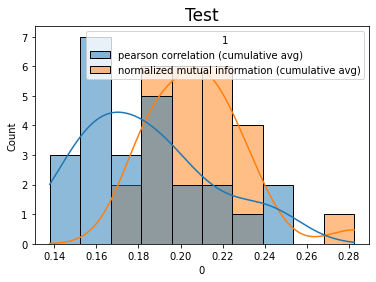

<Figure size 432x288 with 0 Axes>

In [13]:
# rewards
    
if do_salient_objects:
    
    num_runs = 25
    
    # randomly sample hyper_multiple for 1% of the pixels
    indices = np.random.randint(0, hyper_multiple.shape[0], int(hyper_multiple.shape[0]*0.01))
    hyper_multiple = hyper_multiple[indices, :]
    print('The shape of the sub-sampled vertically stacked images:', hyper_multiple.shape)
    
    correlations = []
    for i in range(num_runs):
        correlations.append(calculate_correlations(hyper_multiple, num_bands_originally=hyper_multiple.shape[-1], num_bands_kept=10))
    print(f'\nCorrelation reward for random 10 bands, x{num_runs} runs:', np.mean(correlations))
    
    mis = []
    for i in range(num_runs):
        mis.append(calculate_mutual_infos(hyper_multiple, num_bands_originally=hyper_multiple.shape[-1], num_bands_kept=10))
    print(f'Normalized mutual information reward for random 10 bands, x{num_runs} runs:', np.mean(mis))
    
    # plot rewards
    a_string = ['pearson correlation (cumulative avg)'] * len(correlations)    
    b_string = ['normalized mutual information (cumulative avg)'] * len(mis)
    strings = a_string + b_string
    pd_df = pd.DataFrame([correlations+mis, strings]).T
    pd_df[0] = pd_df[0].astype(float, copy=True)
    sns.histplot(data=pd_df, bins=20, x=0, hue=1, kde=True)
    plt.title(f'Test', fontsize=17)
    #plt.xlim([0,1])
    plt.show()
    plt.figure()